In [100]:
import numpy as np
from glob import glob
import matplotlib.pyplot as plt
import gc
import xarray as xr
import pandas as pd
import xrft as xrft
import warnings
import sys
import seawater as sw
sys.path.append("/homes/metogra/iufarias/FeedbackSubmeso/useful/")
import romspickle
import xroms 
from pyspec import spectrum


from dask.diagnostics import ProgressBar

import scipy.integrate as integ
warnings.filterwarnings("ignore")

In [2]:

plt.rcParams['text.usetex'] = True
plt.rcParams.update({'font.size': 22})

plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Lucida Grande']

In [69]:

path='/data/pacific/lrenault/SASI/CROCO/FULL/'
listm=glob(path+'surf*.nc');listm.sort()
# varf=xr.open_dataset(listm[-9:][xmon])
varf=xr.open_mfdataset(listm[1:-1],data_vars='minimal')
# varf=varf.expand_dims(['s_rho','s_w'])


path='/data/pacific/lrenault/SASI/CROCO/SMTH/'
listt=glob(path+'surf*SASI_6h_his_20*_*.nc');listt.sort()
#vart=xr.open_dataset(listt[xmon])
vart=xr.open_mfdataset(listt[1:],data_vars='minimal')
# vart=vart.expand_dims('s_rho')

In [31]:
dxx=0.5
dyy=dxx

In [32]:
import datetime

# t_ind=pd.DatetimeIndex(varf.time_counter.compute())
t_ind=varf.time_counter.groupby("time_counter.dayofyear").mean()
t_ind_h=varf.time_counter


mon_ind=t_ind.dt.month
mes=np.array([12,1,2,3,4,5,6,7])
mes_str=['Dec/11','Jan/12','Feb/12','Mar/12','Apr/12','May/12','Jun/12','Jul/12']

## Calculating surface PE

In [17]:
B_full=xr.open_dataset('/homes/metogra/iufarias/Documents/data/new_spec/B_full_total.nc')['__xarray_dataarray_variable__'][:,0,:] #multiply by N2r before
B_smth=xr.open_dataset('/homes/metogra/iufarias/Documents/data/new_spec/B_smth_total.nc')['__xarray_dataarray_variable__'][:,0,:]


n2_full=xr.open_dataarray('/homes/metogra/iufarias/Documents/data/new_spec/N2z_mean_full_total.nc')[:,0]
n2_smth=xr.open_dataarray('/homes/metogra/iufarias/Documents/data/new_spec/N2z_mean_smth_total.nc')[:,0]


In [18]:
n2_compromise=(n2_full.mean(axis=0)+ n2_smth.mean(axis=0))/2

epe_full=(1/(2*n2_compromise.data))*B_full
epe_smth=(1/(2*n2_compromise.data))*B_smth

## Calculating surface KE

In [20]:
eke_full=xr.open_dataset('/homes/metogra/iufarias/Documents/data/new_spec/Eke_full_total.nc')['__xarray_dataarray_variable__'][:,0,:]
eke_smth=xr.open_dataset('/homes/metogra/iufarias/Documents/data/new_spec/Eke_smth_total.nc')['__xarray_dataarray_variable__'][:,0,:]

## Calculating vorticity and divergence

In [35]:
%%time
chunks_new={'time_counter':1}

uf=varf.u#.groupby("time_counter.dayofyear").mean()
uf=uf.chunk(chunks=chunks_new);
# u_f=(uf[:,1:,:]+uf[:,:-1,:])/2
uf=uf.compute();

ut=vart.u#.groupby("time_counter.dayofyear").mean()
ut=ut.chunk(chunks=chunks_new);
# ut=(ut[:,1:,:]+ut[:,:-1,:])/2
ut=ut.compute();

vf=varf.v#.groupby("time_counter.dayofyear").mean()
vf=vf.chunk(chunks=chunks_new);
# vf=(vf[:,:,1:]+vf[:,:,:-1])/2
vf=vf.compute();

vt=vart.v#.groupby("time_counter.dayofyear").mean()
vt=vt.chunk(chunks=chunks_new);
# vt=(vt[:,:,1:]+vt[:,:,:-1])/2
vt=vt.compute();



CPU times: user 10.8 s, sys: 16.3 s, total: 27.1 s
Wall time: 3min 25s


In [36]:
uf,vf,_=romspickle.uvw2rho_3d(uf,vf,uf)
uf,vf=uf[:,120:-120,120:800],vf[:,120:-120,120:800]

ut,vt,_=romspickle.uvw2rho_3d(ut,vt,ut)
ut,vt=ut[:,120:-120,120:800],vt[:,120:-120,120:800]

In [77]:
zeta_full=  xr.apply_ufunc(np.gradient,vf,kwargs={'axis':1})/dxx - xr.apply_ufunc(np.gradient,uf.rename({'y_u':'y_v','x_u':'x_v'}),kwargs={'axis':2})/dxx
zeta_smth=  xr.apply_ufunc(np.gradient,vt,kwargs={'axis':1})/dxx - xr.apply_ufunc(np.gradient,ut.rename({'y_u':'y_v','x_u':'x_v'}),kwargs={'axis':2})/dxx


sigma_full=  xr.apply_ufunc(np.gradient,uf.rename({'y_u':'y_v','x_u':'x_v'}),kwargs={'axis':2})/dxx + xr.apply_ufunc(np.gradient,vf,kwargs={'axis':1})/dxx
sigma_smth=  xr.apply_ufunc(np.gradient,ut.rename({'y_u':'y_v','x_u':'x_v'}),kwargs={'axis':2})/dxx + xr.apply_ufunc(np.gradient,vt,kwargs={'axis':1})/dxx

In [78]:
# zeta_full=  uf*0 + (np.gradient(vf,axis=1)/dxx - np.gradient(uf,axis=2)/dxx)
# zeta_smth=  ut*0 + (np.gradient(vt,axis=1)/dxx - np.gradient(ut,axis=2)/dxx)
# sigma_full=  uf*0 + (np.gradient(uf,axis=2)/dxx + np.gradient(vf,axis=1)/dxx)
# sigma_smth=  ut*0 + (np.gradient(ut,axis=2)/dxx + np.gradient(vt,axis=1)/dxx)

In [79]:
nf=2
wdws='hann' #'flattop','hann'
wdw_cor=True
scl='density'

In [81]:
with ProgressBar():
    zeta_full_ispec=xrft.isotropic_power_spectrum(zeta_full,dim=['x_v','y_v'],nfactor=nf,truncate='True',scaling=scl,detrend='linear', 
                                     window=wdws,window_correction=wdw_cor)
    zeta_smth_ispec=xrft.isotropic_power_spectrum(zeta_smth,dim=['x_v','y_v'],nfactor=nf,truncate='True',scaling=scl,detrend='linear', 
                                     window=wdws,window_correction=wdw_cor)
    sigma_full_ispec=xrft.isotropic_power_spectrum(sigma_full,dim=['x_v','y_v'],nfactor=nf,truncate='True',scaling=scl,detrend='linear', 
                                     window=wdws,window_correction=wdw_cor)
    sigma_smth_ispec=xrft.isotropic_power_spectrum(sigma_smth,dim=['x_v','y_v'],nfactor=nf,truncate='True',scaling=scl,detrend='linear', 
                                     window=wdws,window_correction=wdw_cor)

### Intertial period

In [97]:
T_ind=np.int((2*np.pi/sw.f(lat=36.6))/(60*60*6))


def plot_chi_error(ki,spec,sn,color='red',label=None,ci=0.95,alpha=0.25):

    Eu,El=spectrum.spec_error(spec,sn=sn, ci=ci)
    return plt.fill_between(ki,El,Eu, color=color, label=None,alpha=alpha)


## Plot

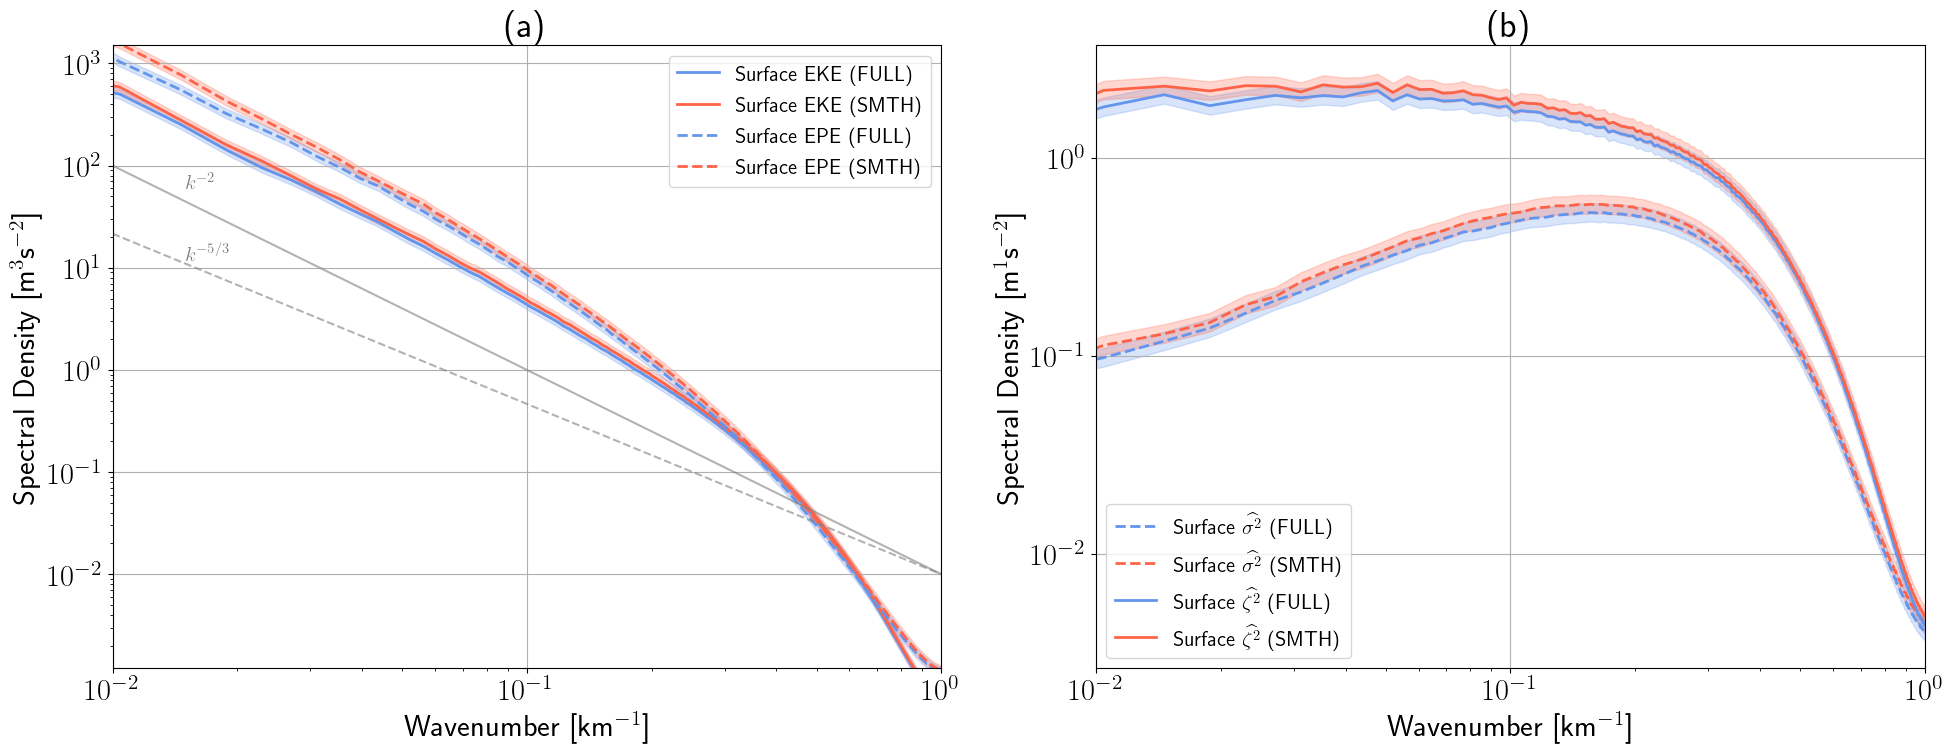

In [107]:
plt.rcParams['text.usetex'] = True
plt.figure(figsize=(20,8))

plt.subplot(1,2,1)


plt.plot((eke_full.freq_r/dxx),eke_full.mean(axis=0)/dxx*1e3,label='Surface EKE (FULL)',linewidth=2,color='cornflowerblue')
plot_chi_error(eke_full.freq_r/dxx,spec=eke_full.mean(axis=0)/dxx*1e3,sn=728/T_ind,color='cornflowerblue')

plt.plot((eke_smth.freq_r/dxx),eke_smth.mean(axis=0)/dxx*1e3,label='Surface EKE (SMTH)',linewidth=2,color='tomato')
plot_chi_error(eke_smth.freq_r/dxx,spec=eke_smth.mean(axis=0)/dxx*1e3,sn=728/T_ind,color='tomato')


plt.plot((epe_full.freq_r/dxx),epe_full.mean(axis=0)/dxx*1e3,label='Surface EPE (FULL)',linestyle='--',linewidth=2,color='cornflowerblue')
plot_chi_error(epe_full.freq_r/dxx,spec=epe_full.mean(axis=0)/dxx*1e3,sn=728/T_ind,color='cornflowerblue')
       
plt.plot((epe_smth.freq_r/dxx),epe_smth.mean(axis=0)/dxx*1e3,label='Surface EPE (SMTH)',linestyle='--',linewidth=2,color='tomato')
plot_chi_error(epe_smth.freq_r/dxx,spec=epe_smth.mean(axis=0)/dxx*1e3,sn=728/T_ind,color='tomato')

# plt.plot([1/50,1/50],[1000,0],'k--')

# plt.text(2e-2,0.94e1,r'Surface EKE',color='grey',fontsize=15)
# plt.text(2e-2,0.4e3,r'Surface EPE',color='grey',fontsize=15)


k = np.array([1/100,1])
E2 = 1/k**2/(10**2)
E5_3 = 1/k**(5/3)/(10**2)

plt.plot(k,E2,'-',color='grey',alpha=0.6)
plt.plot(k,E5_3,'--',color='grey',alpha=0.6)
plt.text(1.5e-2,6e1,r'$k^{-2}$',color='grey',fontsize=15)
plt.text(1.5e-2,12e0,r'$k^{{-5}/{3}}$',color='grey',fontsize=15)


plt.xlabel(r'Wavenumber  [km$^{-1}$]')
plt.ylabel(r'Spectral Density [m$^{3}$s$^{-2}$]')

plt.yscale('log')
plt.xscale('log')

plt.ylim(1.2e-3,1.5e3)
plt.xlim(1e-2,1)
plt.grid()
plt.title('(a)')
plt.legend(fontsize=15)

plt.subplot(1,2,2)



plt.plot(sigma_full_ispec.freq_r/dxx,sigma_full_ispec.mean(axis=0)/dxx*1e3,label='Surface $\widehat{\sigma^2}$ (FULL)',linestyle='--',linewidth=2,color='cornflowerblue')
plot_chi_error(sigma_full_ispec.freq_r/dxx,spec=sigma_full_ispec.mean(axis=0)/dxx*1e3,sn=728/T_ind,color='cornflowerblue')


plt.plot(sigma_smth_ispec.freq_r/dxx,sigma_smth_ispec.mean(axis=0)/dxx*1e3,label='Surface $\widehat{\sigma^2}$ (SMTH)',linestyle='--',linewidth=2,color='tomato')
plot_chi_error(sigma_smth_ispec.freq_r/dxx,spec=sigma_smth_ispec.mean(axis=0)/dxx*1e3,sn=728/T_ind,color='tomato')


plt.plot(zeta_full_ispec.freq_r/dxx,zeta_full_ispec.mean(axis=0)/dxx*1e3,label='Surface $\widehat{\zeta^2}$ (FULL)',linewidth=2,color='cornflowerblue')
plot_chi_error(zeta_full_ispec.freq_r/dxx,spec=zeta_full_ispec.mean(axis=0)/dxx*1e3,sn=728/T_ind,color='cornflowerblue')


plt.plot(zeta_smth_ispec.freq_r/dxx,zeta_smth_ispec.mean(axis=0)/dxx*1e3,label='Surface $\widehat{\zeta^2}$ (SMTH)',linewidth=2,color='tomato')
plot_chi_error(zeta_smth_ispec.freq_r/dxx,spec=zeta_smth_ispec.mean(axis=0)/dxx*1e3,sn=728/T_ind,color='tomato')


plt.legend(fontsize=15)

plt.xlabel(r'Wavenumber  [km$^{-1}$]')
plt.ylabel(r'Spectral Density [m$^{1}$s$^{-2}$]')

plt.yscale('symlog',linthresh=1e-6)
plt.xscale('log')


plt.xlim(1e-2,1)
plt.grid()
plt.title('(b)')
plt.tight_layout()

# plt.savefig('/homes/metogra/iufarias/Documents/figures/2_CROCO/CROCO_surface/total_avg/div_vort_spectral_both.png')



